In [1]:
import pystac_client
import planetary_computer as pc

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import os

## Select GBIF year data

In [2]:
# this data was saved to memory from GBIF datset on the Planetary Comp
# see notebook selecting_gbif_data

gbifdata = 'c_edulis_observations.csv'
obs_all = pd.read_csv(os.path.join(os.getcwd(),'aux_data',gbifdata))

obs_all = gpd.GeoDataFrame(
    obs_all,
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= obs_all.decimallongitude,
        y= obs_all.decimallatitude)
)

In [3]:
# select data for year of interest
YEAR = 2018
obs = obs_all.loc[obs_all['year'] == YEAR]
obs = obs[['year',
           'month',
           'geometry', 
           'decimallatitude', 'decimallongitude', 
           'coordinateuncertaintyinmeters',
           'institutioncode']]
obs.reset_index(drop=True, inplace=True)
print('# observations:', obs.shape[0])

# observations: 62


<AxesSubplot:>

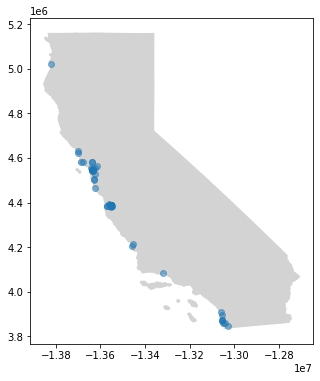

In [4]:
# ---- plot observations over california ----
ca_shape_path = "/home/jovyan/msai4earth-esa/shapefiles_n_rasters/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

fig, ax = plt.subplots(figsize = (6,6))
ca_shape.plot(ax=ax, color='lightgrey')
obs[['geometry']].to_crs(ca_shape.crs).plot(ax=ax, alpha=0.5)

## Find NAIP images covering points

In [5]:
# point = shapely point
# returns the NAIP image covering the point,
#   if there is none it returns None

def query_pt(point, year):

    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["naip"], 
        intersects=point, 
        datetime=date_range)
    
    items =list(search.get_items()) 
    if len(items)==0:
        return None

    # use the first item (most often for NAIP is only one item having a point per year)
    # ** needs to be updated with whatever info we need to queery in QGIS
    return items[0].id

# ----------------------------------------------------------------------------------
# points = GeoDataFrame
# returns a copy of points with a column including the stac_item_id covering each point

def query(points, year):
    
    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")
    
    stac_item_id = []
    for point in points['geometry']:
        search = catalog.search(
            collections=["naip"], 
            intersects=point, 
            datetime=date_range)

        items =list(search.get_items()) 
        if len(items)==0:
            stac_item_id.append(None)
        else:
        # use the first item (most often for NAIP is only one item having a point per year)
        # ** needs to be updated with whatever info we need to queery in QGIS
            stac_item_id.append(items[0].id)
        
    return points.assign(stac_item_id = stac_item_id)

In [6]:
# ---- TEST query_pt ---
pt = obs['geometry'][0]
for i in range(2010,2020):
    print(i, ':',query_pt(pt,i), '\n')

2010 : None 

2011 : None 

2012 : ca_m_3812260_se_10_1_20120520_20120730 

2013 : None 

2014 : ca_m_3812260_se_10_1_20140608_20140923 

2015 : None 

2016 : ca_m_3812260_se_10_.6_20160531_20161004 

2017 : None 

2018 : ca_m_3812260_se_10_060_20180725_20190209 

2019 : None 



In [7]:
# ----- TEST query -----
trial = query(obs,2018)

In [8]:
trial.head()

,year,month,geometry,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,institutioncode,stac_item_id
0,2018.0,4.0,POINT (-122.53049 38.00750),38.007500,-122.530487,5.0,iNaturalist,ca_m_3812260_se_10_060_20180725_20190209
1,2018.0,12.0,POINT (-121.91021 36.62163),36.621633,-121.910213,NaN,iNaturalist,ca_m_3612125_ne_10_060_20180908_20190208
2,2018.0,4.0,POINT (-122.48073 37.79367),37.793672,-122.480735,14.0,iNaturalist,ca_m_3712213_sw_10_060_20180804_20190209
3,2018.0,6.0,POINT (-120.86054 35.37261),35.372605,-120.860542,5.0,iNaturalist,ca_m_3512042_nw_10_060_20180913_20190209
4,2018.0,2.0,POINT (-122.43967 37.43072),37.430723,-122.439666,4.0,iNaturalist,ca_m_3712237_sw_10_060_20180911_20190209


In [9]:
trial.shape

(62, 8)

In [10]:
print(len(set(trial['stac_item_id'])), 'distinct NAIP images cover these points')

29 distinct NAIP images cover these points
